In [17]:
import numpy as np
from numpy import array, sqrt, exp
from hw import Henrard, Jamshidian, hw_helper 
from fox_toolbox.utils import xml_parser, rates, volatility
from mc import mc

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (12, 6.)})
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2

np.random.seed(22)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_CI(df, theor_mean):
    ci95 = 1.96 * df.std() / sqrt(len(df))
    return (theor_mean-ci95, theor_mean + ci95)

In [19]:
OUTPUT_5SWO, INPUT_5SWO = xml_parser.get_files('hw bond 5swo xml', 'hw_bond')
_, irsmout = xml_parser.get_xml(OUTPUT_5SWO)

ref_mr, (hw_buckets, hw_sigma) = xml_parser.get_hw_params(irsmout)
ref_sigmas = rates.Curve(hw_buckets, hw_sigma, 'PieceWise')

In [83]:
T = 5.
U = T 
t = 4.

spotstep = 500
timestep = 50
x0 = 0.

a = ref_mr; mr=ref_mr;
sigma = ref_sigmas
# sigma = rates.Curve(array([ 0.  , 1. , 30.  ]), array([0.01, 0.01, 0.01]), 'PieceWise', '')
hw = mc.HullWhiteProcess( mr = ref_mr, sigma = sigma, x0 = x0, measure = 'RN')
df = hw.generate_paths(until=T, timestep=timestep, spotstep=spotstep)

tt = np.linspace(0, T, timestep+1)

# FORWARD BOND PRICING
<font size="5">
    
$X_{T}=e^{-a(T-t)} X_{t}+\int_{t}^{T} e^{-a(T-s)} \sigma_{s} d W_{s}$ <br>
    
$X_{\mathrm{T}} | \mathcal{F}_{\mathrm{t}} \sim \mathcal{N}\left(\mathrm{e}^{-\mathrm{a}(\mathrm{T}-\mathrm{t})} \mathrm{X}_{\mathrm{t}}, \int_{\mathrm{t}}^{\mathrm{T}} \mathrm{e}^{-2 \mathrm{a}(\mathrm{T}-\mathrm{s})} \sigma_{\mathrm{s}}^{2} \mathrm{d} \mathrm{s}\right)$ <br>
    
$X_{\mathrm{t}} \sim \mathcal{N}\left(0, \int_{\mathrm{0}}^{\mathrm{t}} \mathrm{e}^{-2 \mathrm{a}(\mathrm{t}-\mathrm{s})} \sigma_{\mathrm{s}}^{2} \mathrm{d} \mathrm{s}\right))$ <br>
    
$\mathrm{P}(\mathrm{t}, \mathrm{T})=A(\mathrm{t}, \mathrm{T}) \mathrm{e}^{-\mathrm{B}(\mathrm{t}, \mathrm{T}) \mathrm{X}_{\mathrm{t}}}$
    
$\mathbb{E}^{\mathbb{Q}} \Big[P^{HW}(t,T)\Big] = P^{mkt}(t,T)\ \ \forall t \in [0,T]$
    
    
</font>

In [77]:
OUTPUT_5SWO, INPUT_5SWO = xml_parser.get_files('hw bond 5swo xml', 'hw_bond')

main_curve, sprds = xml_parser.get_rate_curves(INPUT_5SWO)
dsc_curve = main_curve

try:
    estim_curve = sprds[0]
except TypeError:
    estim_curve = main_curve

-5.348232491186611e-05

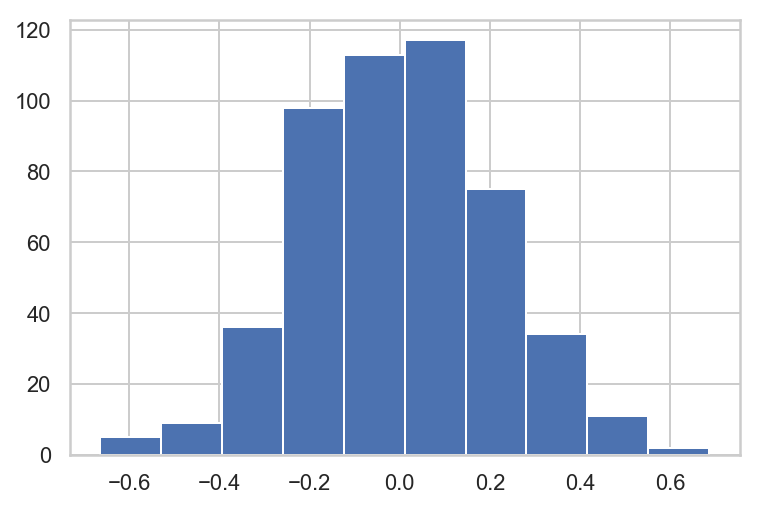

In [78]:
df.loc[t].hist(figsize=(6,4));
df.loc[t].mean()

In [79]:
theor_mean = exp(0.5 * (hw_helper._V(0, t, t, a, sigma) - hw_helper._V(0, t, T, a, sigma)) + 0.5 * hw_helper._B(t, T, a)**2 * hw_helper.get_var_x(t, a, sigma) )
print(theor_mean)

0.9171509712853614


<font color = red>
    should be 1.0 !!!

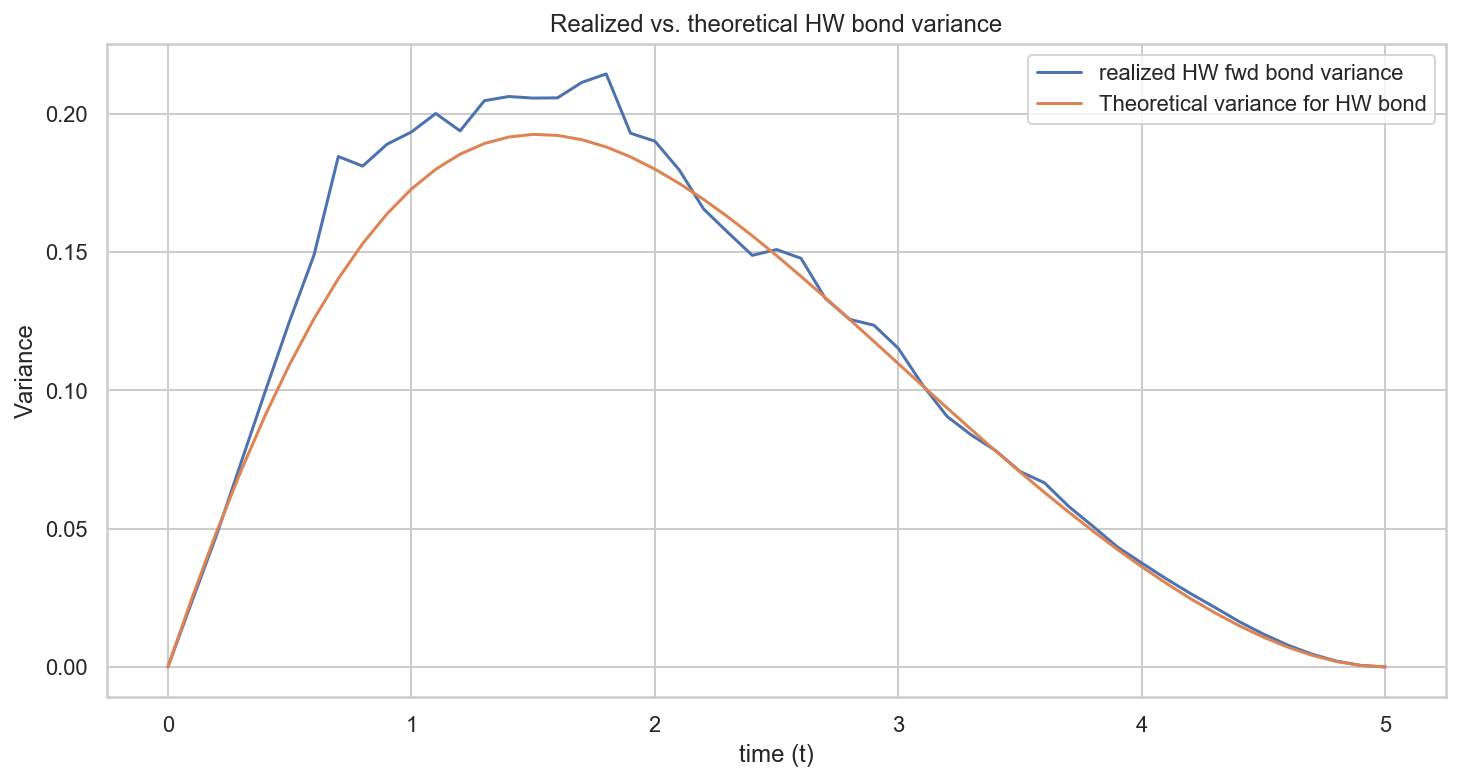

In [80]:
plt.plot(tt, [df.loc[t].apply(lambda x: hw.fwd_bond(t, T, dsc_curve, x)).std()**2 for t in tt], label = 'realized HW fwd bond variance');
plt.plot(tt, [hw_helper.get_var_p(t, T, a, sigma ,dsc_curve) for t in tt], label = 'Theoretical variance for HW bond');
plt.title('Realized vs. theoretical HW bond variance'); plt.xlabel('time (t)'); plt.ylabel('Variance'); plt.legend()

## theoretical Bond volatility is OK with simulation
<font color = green>

<font size="5">
    
$P(t, T)=\frac{P^{M}(0, T)}{P^{M}(0, t)} e^{\frac{1}{2}\Big[V(0,\ t,\ t)-V(0,\ t,\ T)\Big] -B(t,T) X_t} $
    
 $\mathbb{E}^{\mathbb{Q}} e^{\frac{1}{2}[V(0,\ t,\ t)-V(0,\ t,\ T)] -B(t,T) X_t} = e^{\frac{1}{2}[V(0,\ t,\ t)-V(0,\ t,\ T)] + \frac{1}{2}B^2(t,T) \sigma_x^2}  $
</font>

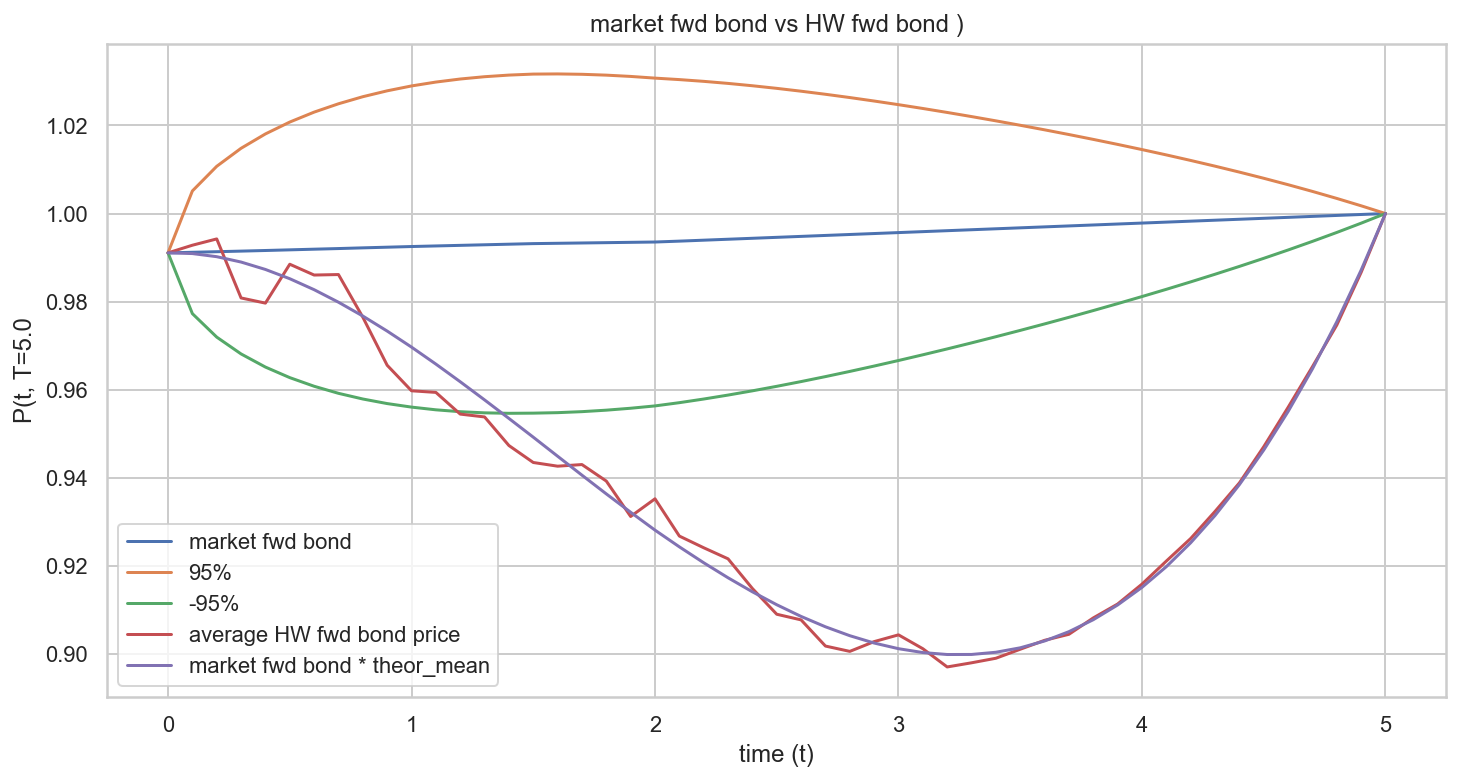

In [81]:
plt.plot(tt, [dsc_curve.get_fwd_dsc(t,T) for t in tt], label = 'market fwd bond');

plt.plot(tt, [ dsc_curve.get_fwd_dsc(t,T) + 1.96 * sqrt(hw_helper.get_var_p(t, T, a, sigma ,dsc_curve) / spotstep) for t in tt], label = '95%');
plt.plot(tt, [ dsc_curve.get_fwd_dsc(t,T) - 1.96 * sqrt(hw_helper.get_var_p(t, T, a, sigma ,dsc_curve) / spotstep) for t in tt], label = '-95%');

plt.plot(tt, [df.loc[t].apply(lambda x: hw.fwd_bond(t, T, dsc_curve, x)).mean() for t in tt], label = 'average HW fwd bond price');

plt.plot(tt, [dsc_curve.get_fwd_dsc(t,T) * exp(0.5 * (hw_helper._V(0, t, t, a, sigma) - hw_helper._V(0, t, T, a, sigma)) + 0.5 * hw_helper._B(t, T, a)**2 * hw_helper.get_var_x(t, a, sigma) ) for t in tt], label = 'market fwd bond * theor_mean');

plt.title('market fwd bond vs HW fwd bond )'); plt.xlabel('time (t)'); plt.ylabel(f'P(t, T={T}'); plt.legend();

In [15]:
print('RiskNeutral ')
Discount_0_4_5 = 0.9978351813686
Discount_4_4_5 = 0.7906440904503
Pay_4_5 = 0.7906440904503
Pay_5_5 = 0.7890402926381

print(Discount_0_4_5 - dsc_curve.get_fwd_dsc(t,T))
print(Pay_5_5 - dsc_curve.get_dsc(T))
print(Discount_4_4_5 - df.loc[t].apply(lambda x: hw.fwd_bond( t, T, dsc_curve, x)).mean())

RiskNeutral 
4.340972026284362e-14
-0.20203609332419648
-0.12358358651065404


<font size = 7>
Try to price Bond P(t,M) where M<T.<br>
Price P(T,M, "Xt") with HW formula then capitalize it to T by multiplying 1/P(t,T, "Xt") then by market bond P(0,T)
    </font>

## Smoothness metric (check Kostia mail with .py) + TSR + MXTEST